## 1. Loading Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from pandas_datareader import data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("CSUSHPISA.csv")

In [3]:
df.head()

,DATE,CSUSHPISA
0,1987-01-01,63.965
1,1987-02-01,64.424
2,1987-03-01,64.736
3,1987-04-01,65.132
4,1987-05-01,65.563


In [4]:
df.tail()

,DATE,CSUSHPISA
435,2023-04-01,300.198
436,2023-05-01,302.620
437,2023-06-01,304.651
438,2023-07-01,306.634
439,2023-08-01,309.404


In [5]:
df.shape

(440, 2)

- We have monthly pricing data for 20 years, starting from 1-01-1987 to 1-08-2023.
- Using publicly available data we have to find for key factors that influence US home prices nationally. Then, we have to build a data science model that explains how these factors impacted home prices over the last 20 years.

Let us do some basic exploration and find out if the given data has any trend or seasonal patterns.

## 2. Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       440 non-null    object 
 1   CSUSHPISA  440 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])

- We can use the pandas_datareader library to fetch the key factors, i.e., mortgage interest rates, the US unemployment rate, GDP growth, consumer confidence, housing inventory levels, population growth and building permits.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       440 non-null    datetime64[ns]
 1   CSUSHPISA  440 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.0 KB


In [9]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Function to fetch additional data for a given key factor
def fetch_additional_data(symbol, start_date, end_date, column_name):
    additional_df = data.DataReader(symbol, 'fred', start_date, end_date)
    additional_df.reset_index(inplace=True)
    additional_df.rename(columns={symbol: column_name}, inplace=True)
    return additional_df

interest_rates_df = fetch_additional_data('GS10', df['DATE'].min(), df['DATE'].max(), 'INTEREST_RATES')

unemployment_rate_df = fetch_additional_data('UNRATE', df['DATE'].min(), df['DATE'].max(), 'UNEMPLOYMENT_RATE')

gdp_growth_df = fetch_additional_data('GDP', df['DATE'].min(), df['DATE'].max(), 'GDP_GROWTH')

consumer_confidence_df = fetch_additional_data('UMCSENT', df['DATE'].min(), df['DATE'].max(), 'CONSUMER_CONFIDENCE')

housing_inventory_df = fetch_additional_data('MSACSR', df['DATE'].min(), df['DATE'].max(), 'HOUSING_INVENTORY')

population_growth_df = fetch_additional_data('POPTHM', df['DATE'].min(), df['DATE'].max(), 'POPULATION_GROWTH')

building_permits_df = fetch_additional_data('PERMIT', df['DATE'].min(), df['DATE'].max(), 'BUILDING_PERMITS')

# Merging additional data with the existing S&P Case-Shiller Home Price Index data
df = pd.merge(df, interest_rates_df, on='DATE', how='left')
df = pd.merge(df, unemployment_rate_df, on='DATE', how='left')
df = pd.merge(df, gdp_growth_df, on='DATE', how='left')
df = pd.merge(df, consumer_confidence_df, on='DATE', how='left')
df = pd.merge(df, housing_inventory_df, on='DATE', how='left')
df = pd.merge(df, population_growth_df, on='DATE', how='left')
df = pd.merge(df, building_permits_df, on='DATE', how='left')

# Using forward-fill to fill missing values in the entire dataframe
df.ffill(inplace=True)

# Display the updated dataframe
print(df.head())


        DATE  CSUSHPISA  INTEREST_RATES  UNEMPLOYMENT_RATE  GDP_GROWTH  \
0 1987-01-01     63.965            7.08                6.6    4722.156   
1 1987-02-01     64.424            7.25                6.6    4722.156   
2 1987-03-01     64.736            7.25                6.6    4722.156   
3 1987-04-01     65.132            8.02                6.3    4806.160   
4 1987-05-01     65.563            8.61                6.3    4806.160   

   CONSUMER_CONFIDENCE  HOUSING_INVENTORY  POPULATION_GROWTH  BUILDING_PERMITS  
0                 90.4                6.0           241857.0            1690.0  
1                 90.2                6.2           242005.0            1689.0  
2                 90.8                6.0           242166.0            1704.0  
3                 92.8                6.0           242338.0            1601.0  
4                 91.1                6.7           242516.0            1500.0  


- These are the key factors that influence US home prices nationally. 

## 2. Data Preprocessing

### Plotting Time Series

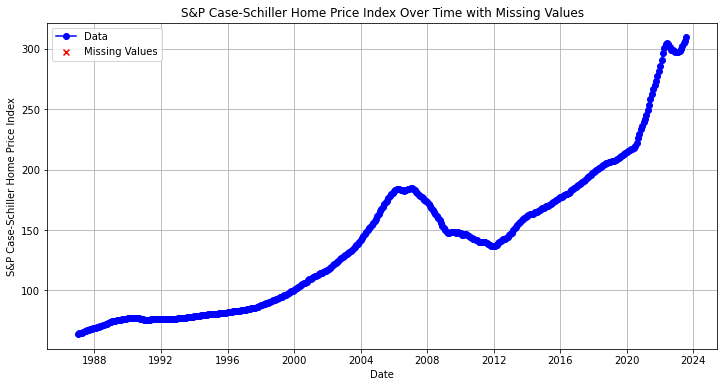

In [11]:
#checking for any missing month and visualizing the time series data

new_df = df.copy()

new_df.index = new_df[('DATE')]
# Creating a time series with complete monthly frequency
complete_time_series = pd.date_range(start=new_df.index.min(), end=new_df.index.max(), freq='MS')

# Merging the complete time series with the data to identify missing months
merged_df = pd.DataFrame(index=complete_time_series).merge(new_df, how='left', left_index=True, right_index=True)

# missing values (NaN) will be highlighted in red
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['CSUSHPISA'], marker='o', color='blue', label='Data')
plt.scatter(merged_df.index[merged_df['CSUSHPISA'].isnull()], merged_df['CSUSHPISA'][merged_df['CSUSHPISA'].isnull()], color='red', marker='x', label='Missing Values')
plt.xlabel('Date')
plt.ylabel('S&P Case-Schiller Home Price Index')
plt.title('S&P Case-Schiller Home Price Index Over Time with Missing Values')
plt.legend()
plt.grid(True)

- This means housing price is slighlty increased in between 2004 to 2008 and then decreased then again in

- There are no missing values

In [12]:
df.describe()

,CSUSHPISA,INTEREST_RATES,UNEMPLOYMENT_RATE,GDP_GROWTH,CONSUMER_CONFIDENCE,HOUSING_INVENTORY,POPULATION_GROWTH,BUILDING_PERMITS
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,141.526198,4.603068,5.772500,13269.087739,86.327955,5.904318,293445.222727,1355.586364
std,60.725890,2.264025,1.677696,5935.292210,12.845685,1.741365,28774.685047,390.414419
min,63.965000,0.620000,3.400000,4722.156000,50.000000,3.300000,241857.000000,513.000000
25%,82.133750,2.642500,4.600000,7868.468000,77.150000,4.500000,268663.000000,1089.750000
50%,140.690000,4.295000,5.400000,12922.656000,89.550000,5.600000,295470.500000,1381.000000
75%,178.314500,6.262500,6.600000,17589.938000,95.025000,6.800000,319496.000000,1623.000000
max,309.404000,9.520000,14.700000,27623.543000,112.000000,12.200000,335501.000000,2263.000000


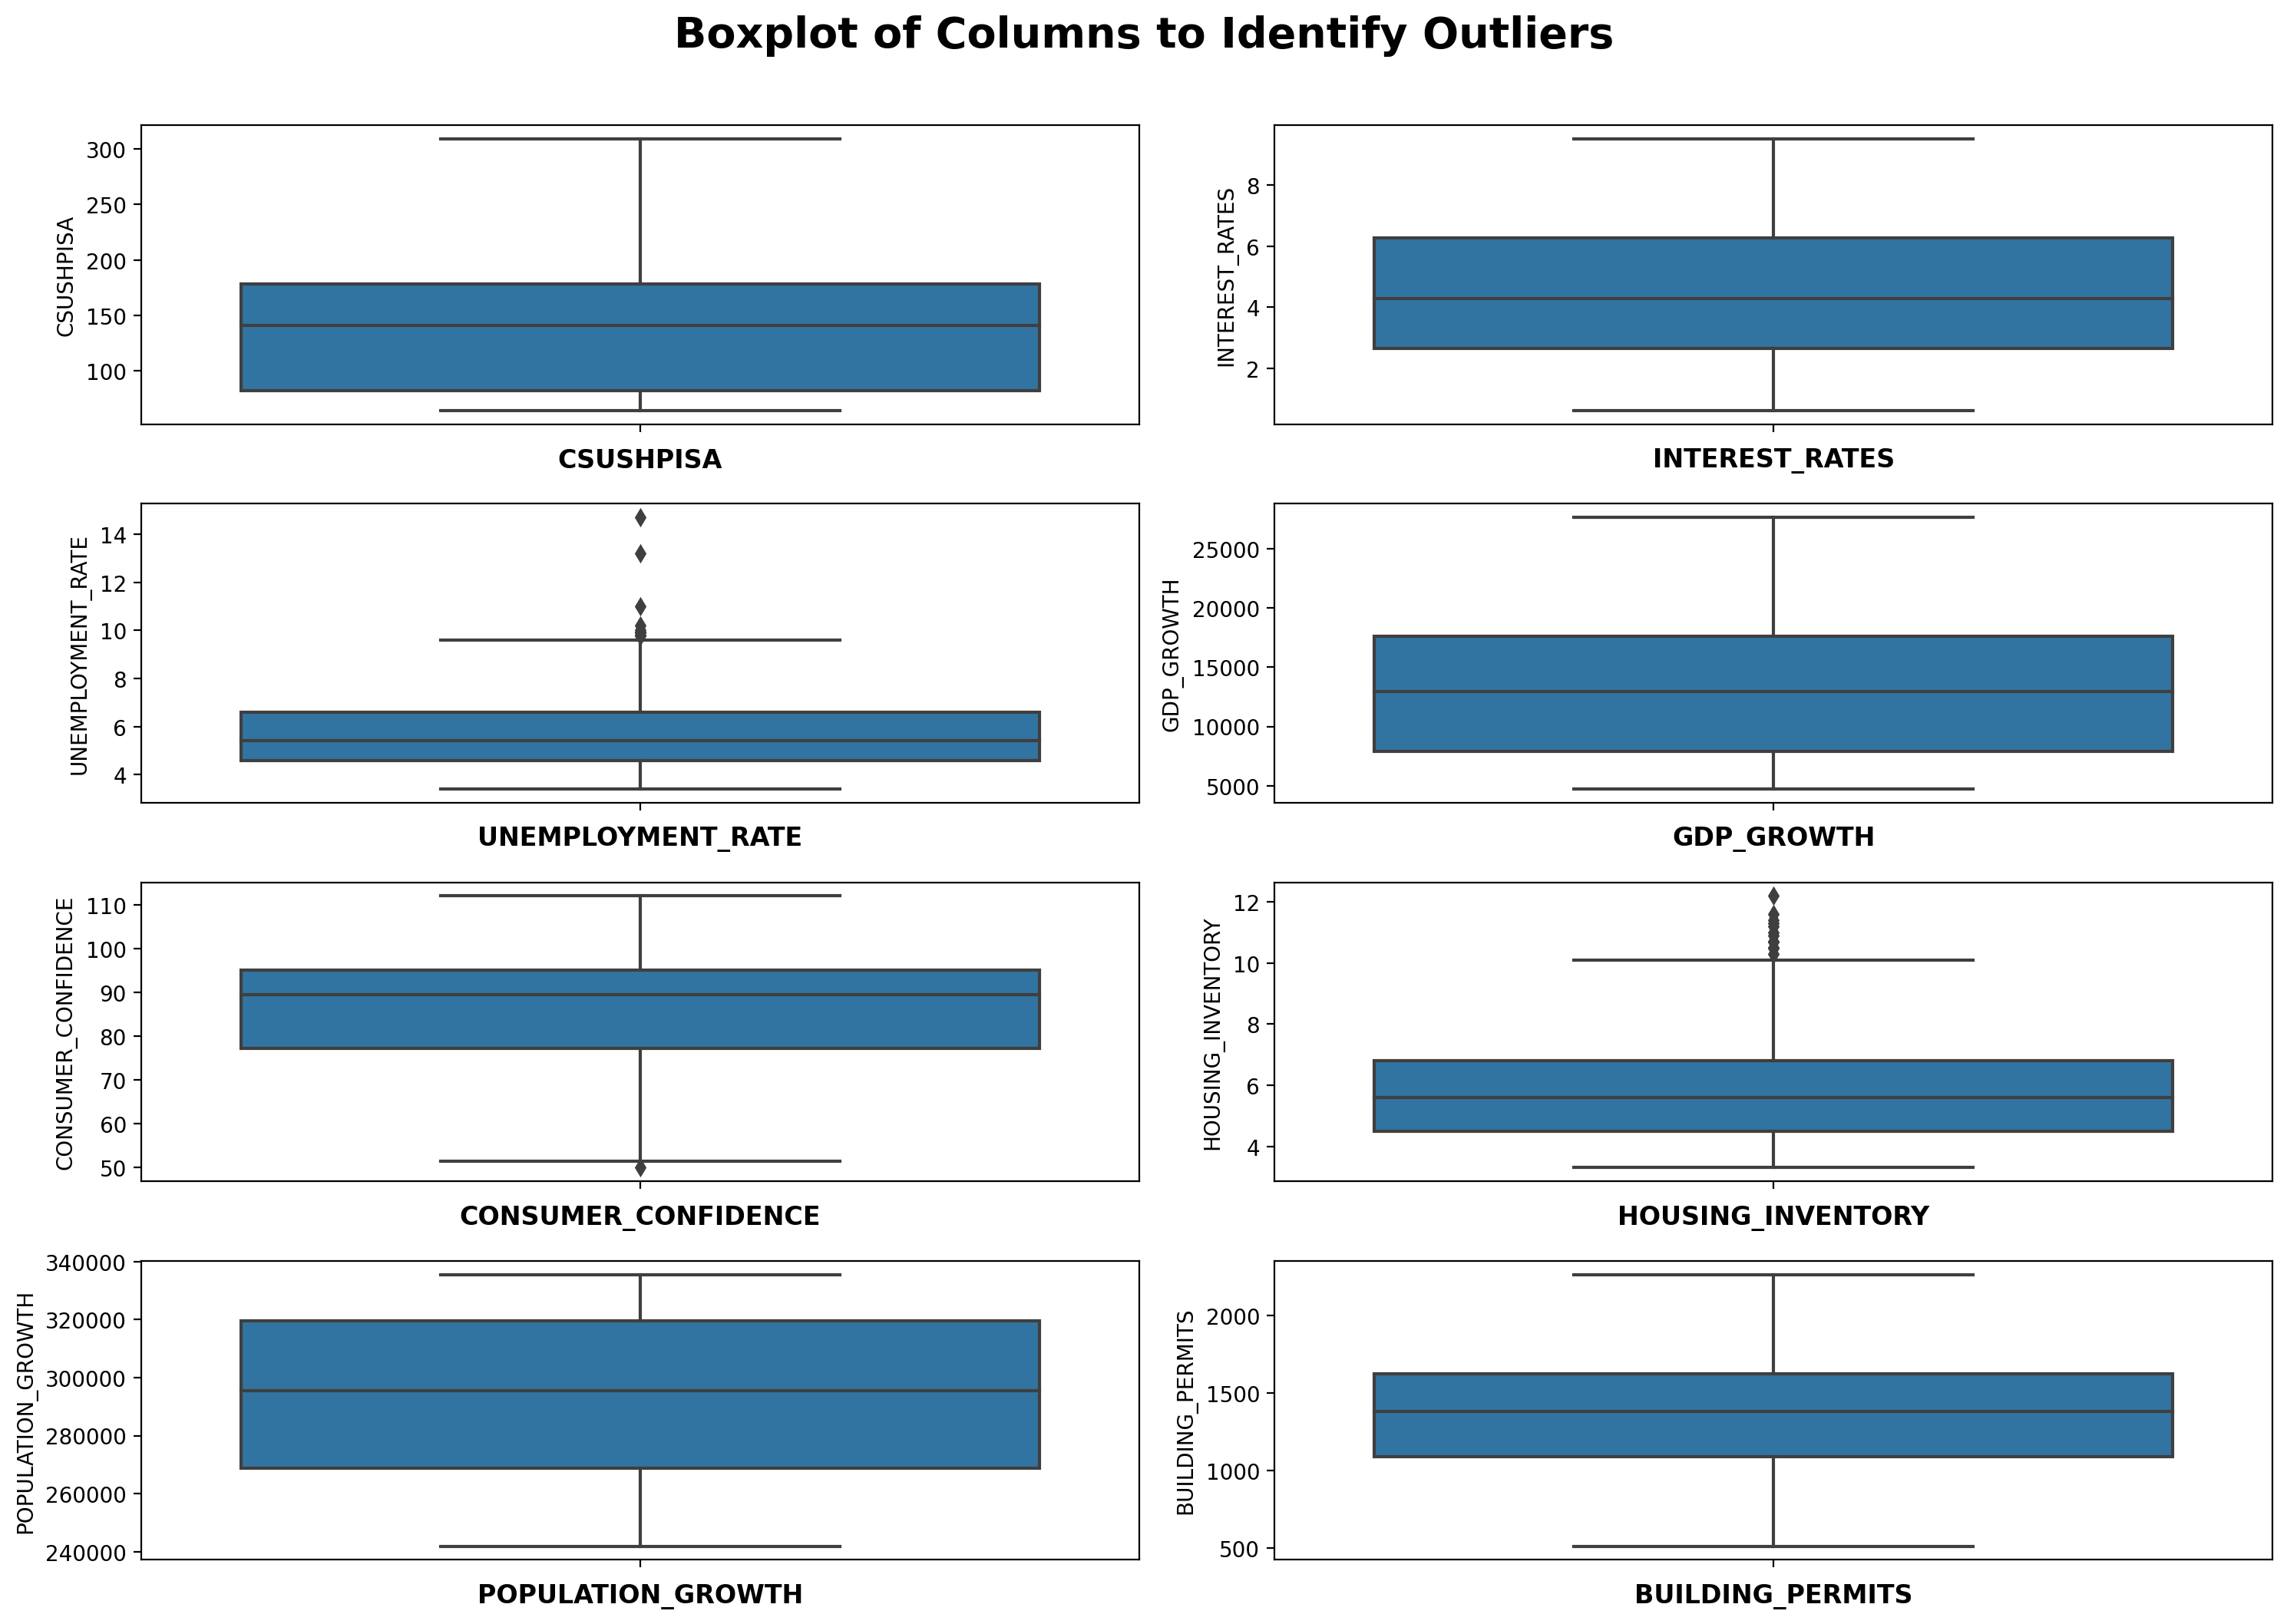

In [13]:
plt.figure(figsize=(15, 15), dpi=200)
plt.suptitle('Boxplot of Columns to Identify Outliers', fontsize=20, fontweight='bold', alpha=1, y=1.01)

i = 0
for col in df.columns:
    if df[col].dtype != 'datetime64[ns]':  # Exclude datetime columns
        numeric_data = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, coerce converts non-numeric to NaN
        numeric_data = numeric_data.dropna()  # Drop NaN values
        plt.subplot(6, 2, i + 1)
        sns.boxplot(y=numeric_data)  # Use y instead of x
        plt.xlabel(col, fontdict={'fontsize': 12, 'fontweight': 'bold'})
        plt.tight_layout()
        i += 1

plt.show()

In [14]:
def get_whisker_boundaries(col):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    IQR = q3 - q1

    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR

    return lower_limit,upper_limit

In [15]:
lower_value, upper_value = get_whisker_boundaries('UNEMPLOYMENT_RATE')

print('Lower Whisker Value is:',lower_value)
print('Upper Whisker Value is:',upper_value)

df_outliers = df.loc[df['UNEMPLOYMENT_RATE']>upper_value]

print('Rows containing outliers:',df_outliers.shape)

Lower Whisker Value is: 1.5999999999999996
Upper Whisker Value is: 9.6
Rows containing outliers: (13, 9)


In [16]:
new_df = df.copy()

#replacing outliers with NaN values
new_df['UNEMPLOYMENT_RATE'] = new_df['UNEMPLOYMENT_RATE'].apply(lambda x: np.nan if x>upper_value else x)

In [17]:
lower_value, upper_value = get_whisker_boundaries('CONSUMER_CONFIDENCE')

print('Lower Whisker Value is:',lower_value)
print('Upper Whisker Value is:',upper_value)

df_outliers = df.loc[df['CONSUMER_CONFIDENCE']>upper_value]

print('Rows containing outliers:',df_outliers.shape)

Lower Whisker Value is: 50.337500000000006
Upper Whisker Value is: 121.8375
Rows containing outliers: (0, 9)


In [18]:
lower_value, upper_value = get_whisker_boundaries('HOUSING_INVENTORY')

print('Lower Whisker Value is:',lower_value)
print('Upper Whisker Value is:',upper_value)

df_outliers = df.loc[df['HOUSING_INVENTORY']>upper_value]

print('Rows containing outliers:',df_outliers.shape)

Lower Whisker Value is: 1.0500000000000003
Upper Whisker Value is: 10.25
Rows containing outliers: (14, 9)


In [19]:
#replacing outliers with NaN values
new_df['HOUSING_INVENTORY'] = new_df['HOUSING_INVENTORY'].apply(lambda x: np.nan if x>upper_value else x)

In [20]:
new_df.isnull().sum()

DATE                    0
CSUSHPISA               0
INTEREST_RATES          0
UNEMPLOYMENT_RATE      13
GDP_GROWTH              0
CONSUMER_CONFIDENCE     0
HOUSING_INVENTORY      14
POPULATION_GROWTH       0
BUILDING_PERMITS        0
dtype: int64

In [21]:
#filling nan values with ffill value

new_df['UNEMPLOYMENT_RATE'] = new_df['UNEMPLOYMENT_RATE'].fillna(method='ffill')
new_df['HOUSING_INVENTORY'] = new_df['HOUSING_INVENTORY'].fillna(method='ffill')

In [22]:
new_df.isnull().sum()

DATE                   0
CSUSHPISA              0
INTEREST_RATES         0
UNEMPLOYMENT_RATE      0
GDP_GROWTH             0
CONSUMER_CONFIDENCE    0
HOUSING_INVENTORY      0
POPULATION_GROWTH      0
BUILDING_PERMITS       0
dtype: int64

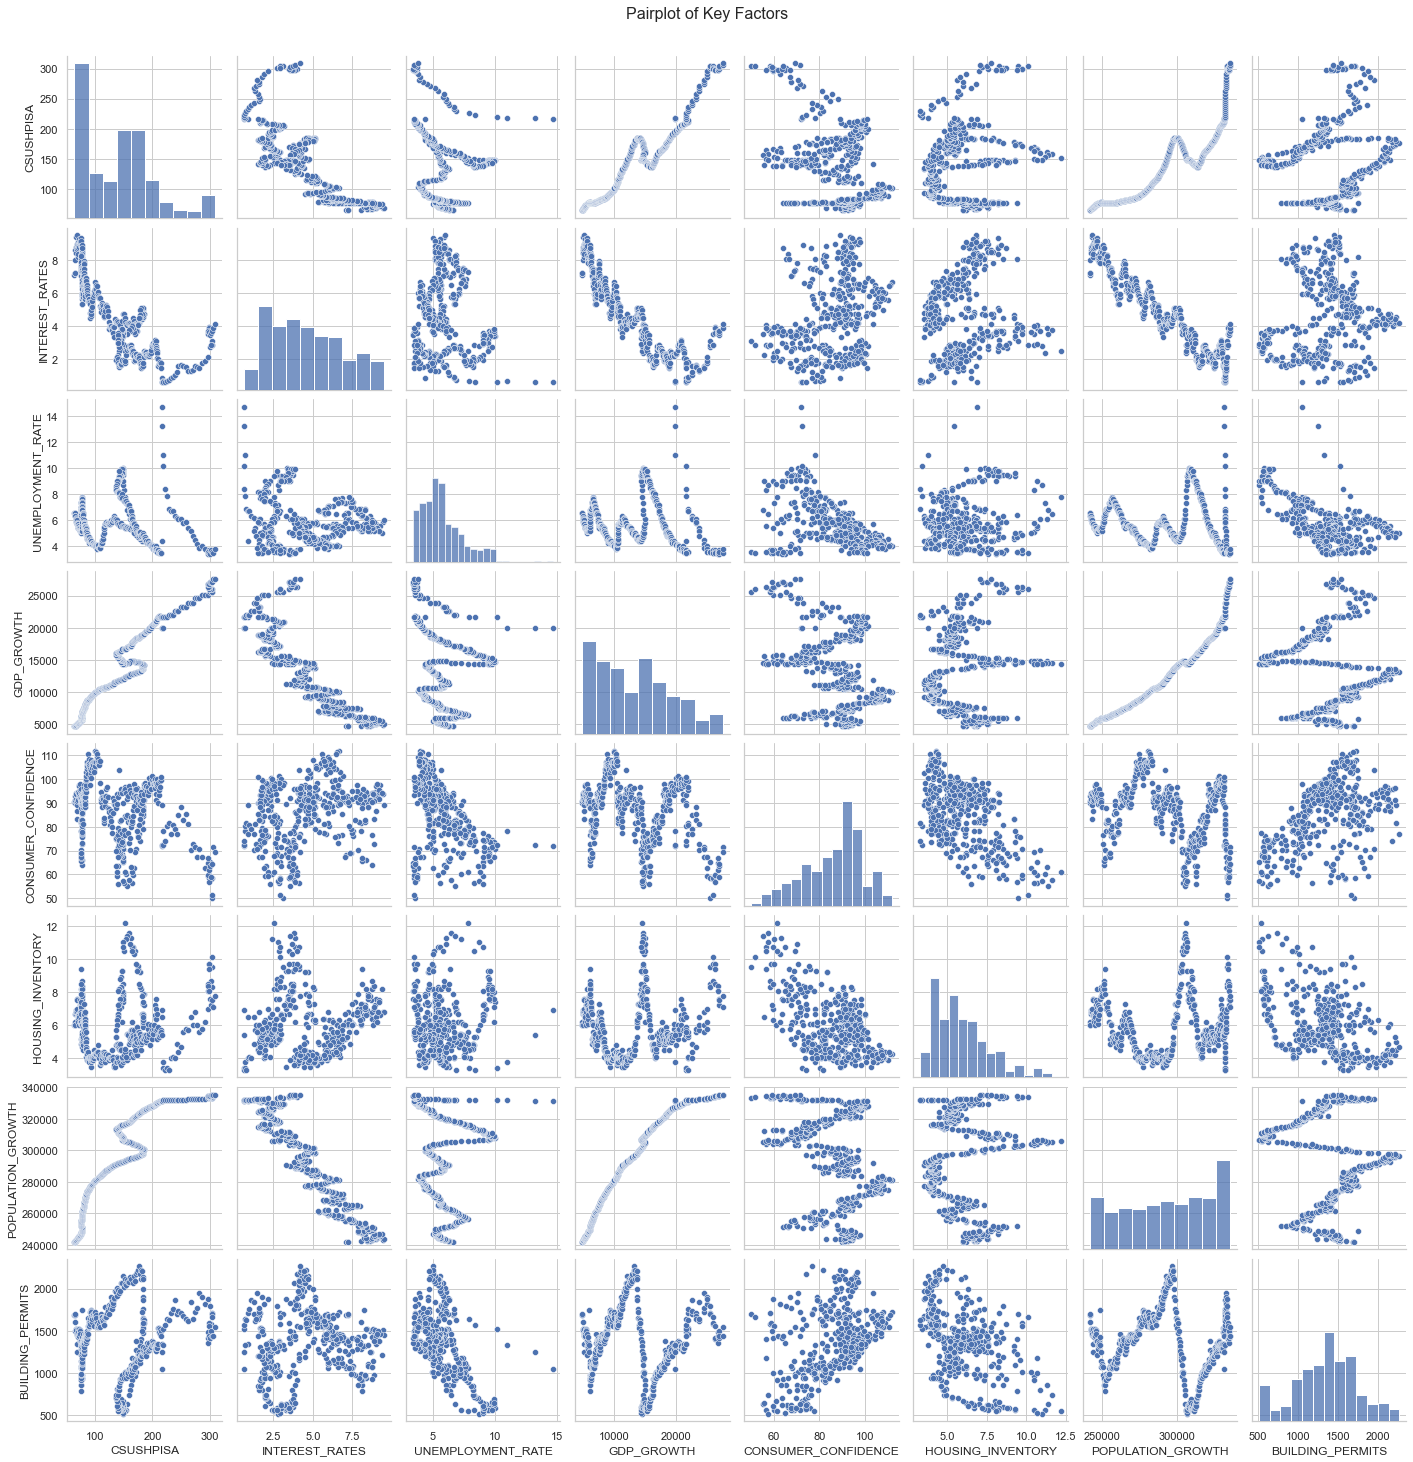

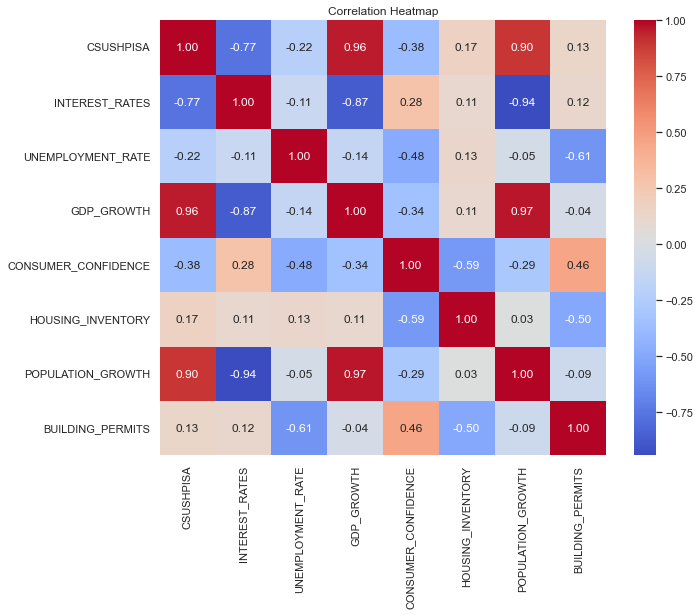

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting relationships using pairplot
sns.pairplot(df[['CSUSHPISA', 'INTEREST_RATES', 'UNEMPLOYMENT_RATE', 'GDP_GROWTH', 'CONSUMER_CONFIDENCE', 'HOUSING_INVENTORY', 'POPULATION_GROWTH', 'BUILDING_PERMITS']])
plt.suptitle('Pairplot of Key Factors', y=1.02, fontsize=16)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

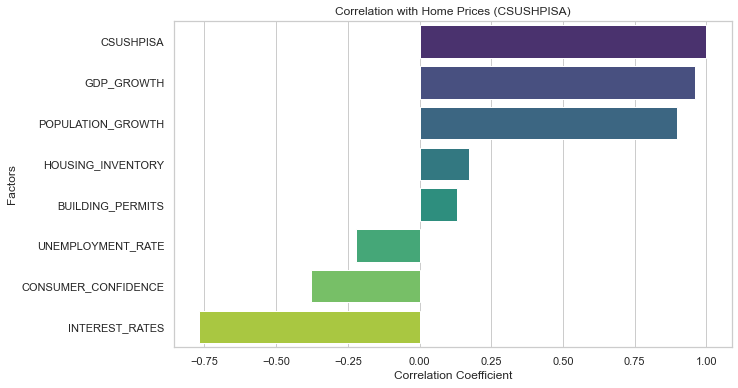

In [24]:
correlation_matrix = df[['CSUSHPISA', 'INTEREST_RATES', 'UNEMPLOYMENT_RATE', 'GDP_GROWTH', 'CONSUMER_CONFIDENCE', 'HOUSING_INVENTORY', 'POPULATION_GROWTH', 'BUILDING_PERMITS']].corr()

# Sorting correlations with home prices (CSUSHPISA)
correlation_with_home_prices = correlation_matrix['CSUSHPISA'].sort_values(ascending=False)

# Plotting the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_home_prices.values, y=correlation_with_home_prices.index, palette='viridis')
plt.title('Correlation with Home Prices (CSUSHPISA)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Factors')
plt.show()

- Home prices tend to decrease as interest rates increase.

- A small tendency for home prices to decrease with rising unemployment.

- Home prices increase with economic growth.

- Lower consumer confidence may lead to lower home prices.

- Slight tendency for home prices to increase with higher housing inventory.

- Home prices tend to increase with population growth.

- Slight tendency for home prices to increase with more building permits issued.

## 3. Feature Extraction and Exploration 

### Decompose Series

we want to decompose the data to seperate the seasonality, trend and residual. Since we have 20 years of sales data. We would expect there's a yearly pattern. Let's use a function seasonal_decompose in statsmodels to help us find it.

In [25]:
decomposed_series = seasonal_decompose(df['CSUSHPISA'],period=12)

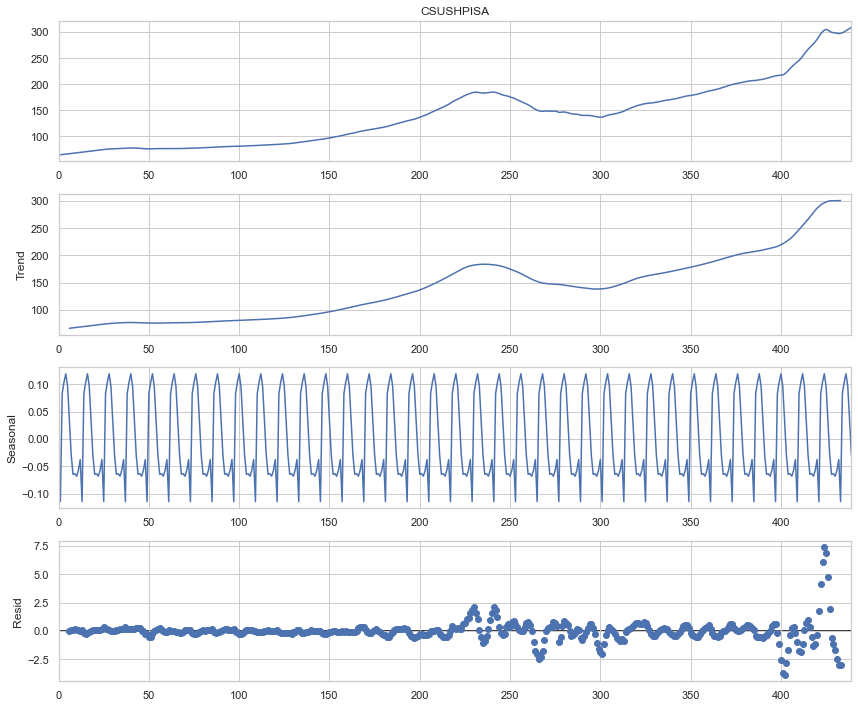

In [26]:
fig = decomposed_series.plot()
fig.set_size_inches((12,10))
fig.tight_layout()

<AxesSubplot:>

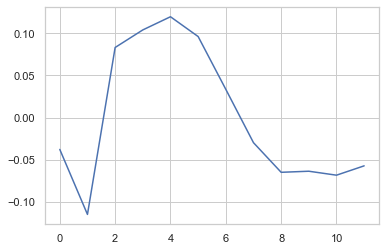

In [27]:
# considering 12 month in a year 
decomposed_series.seasonal[0:12].plot()

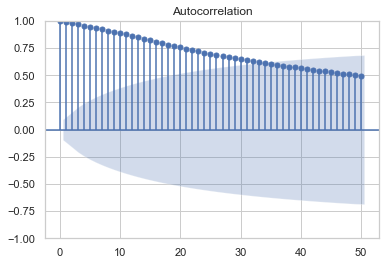

C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


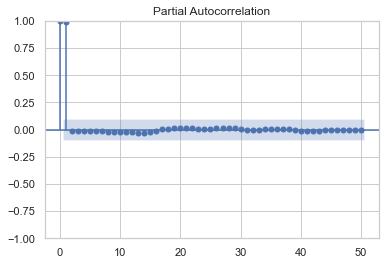

In [28]:
plot_acf(df['CSUSHPISA'], lags=50)
plt.show()

plot_pacf(df['CSUSHPISA'], lags=50)
plt.show()

- Pattern repeats 1 time a year
- This suggests annual seasonality in the data

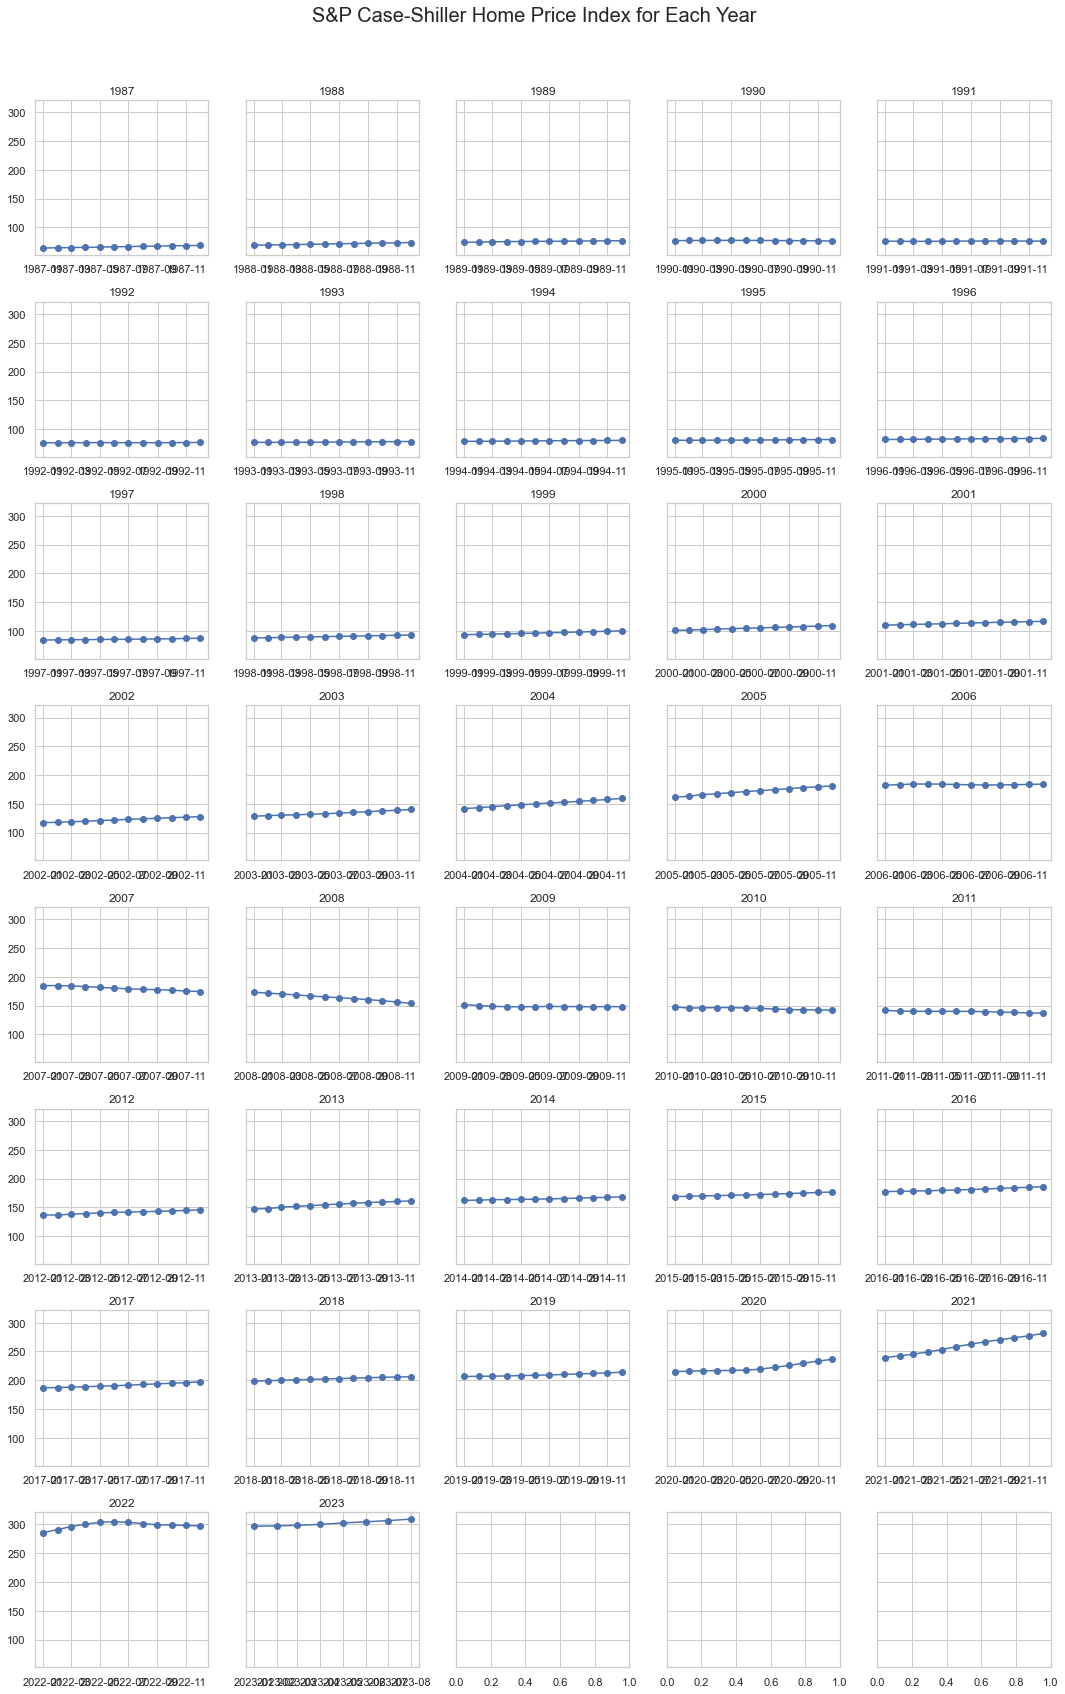

In [29]:
df['Year'] = df['DATE'].dt.year

# Get unique years and calculate the number of rows and columns needed
unique_years = df['Year'].unique()
num_years = len(unique_years)
num_rows = int(np.ceil(num_years / 5))
num_cols = min(num_years, 5)

# Create subplots for each year
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3*num_rows), sharey=True)
fig.suptitle('S&P Case-Shiller Home Price Index for Each Year', fontsize=20)

for i, (year, group) in enumerate(df.groupby('Year')):
    ax = axes[i // num_cols, i % num_cols]
    ax.plot(group['DATE'], group['CSUSHPISA'], marker='o', linestyle='-', color='b')
    ax.set_title(year)
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 6. Model Training

C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lovly\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

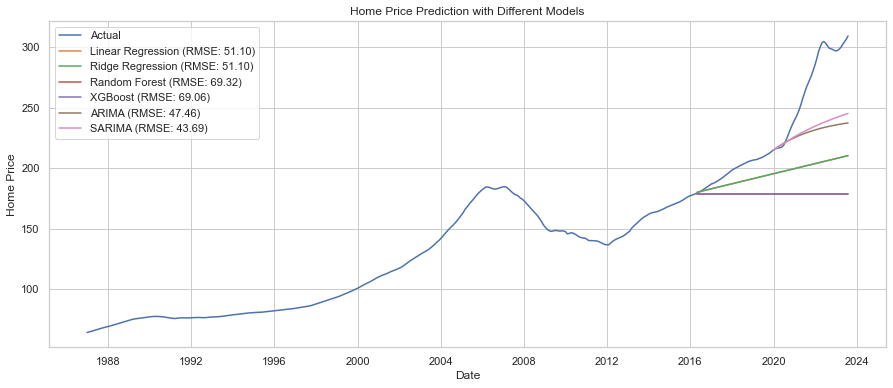

In [30]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Train-test split for linear regression
train_size = int(len(df) * 0.8)
train_linear, test_linear = df[:train_size], df[train_size:]

# Linear Regression
X_train, y_train = np.arange(len(train_linear)).reshape(-1, 1), train_linear['CSUSHPISA'].values
X_test, y_test = np.arange(len(train_linear), len(df)).reshape(-1, 1), test_linear['CSUSHPISA'].values

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train-test split for ARIMA/SARIMA
train_size_arima = int(len(df) * 0.9)
train_arima, test_arima = df[:train_size_arima], df[train_size_arima:]

# ARIMA Model
order = (5, 1, 0)  # Example order, you may need to tune this
arima_model = ARIMA(train_arima['CSUSHPISA'], order=order)
arima_result = arima_model.fit()

# SARIMA Model
order_sarima = (1, 1, 1, 12)  # Example order, you may need to tune this
sarima_model = SARIMAX(train_arima['CSUSHPISA'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Predictions
linear_predictions = linear_model.predict(X_test)
ridge_predictions = ridge_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
arima_predictions = arima_result.predict(start=len(train_arima), end=len(df)-1, typ='levels')
sarima_predictions = sarima_result.predict(start=len(train_arima), end=len(df)-1, typ='levels')

# Evaluate models
linear_rmse = np.sqrt(mean_squared_error(test_linear['CSUSHPISA'], linear_predictions))
ridge_rmse = np.sqrt(mean_squared_error(test_linear['CSUSHPISA'], ridge_predictions))
rf_rmse = np.sqrt(mean_squared_error(test_linear['CSUSHPISA'], rf_predictions))
xgb_rmse = np.sqrt(mean_squared_error(test_linear['CSUSHPISA'], xgb_predictions))
arima_rmse = np.sqrt(mean_squared_error(test_arima['CSUSHPISA'], arima_predictions))
sarima_rmse = np.sqrt(mean_squared_error(test_arima['CSUSHPISA'], sarima_predictions))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['CSUSHPISA'], label='Actual')
plt.plot(test_linear.index, linear_predictions, label=f'Linear Regression (RMSE: {linear_rmse:.2f})')
plt.plot(test_linear.index, ridge_predictions, label=f'Ridge Regression (RMSE: {ridge_rmse:.2f})')
plt.plot(test_linear.index, rf_predictions, label=f'Random Forest (RMSE: {rf_rmse:.2f})')
plt.plot(test_linear.index, xgb_predictions, label=f'XGBoost (RMSE: {xgb_rmse:.2f})')
plt.plot(test_arima.index, arima_predictions, label=f'ARIMA (RMSE: {arima_rmse:.2f})')
plt.plot(test_arima.index, sarima_predictions, label=f'SARIMA (RMSE: {sarima_rmse:.2f})')
plt.title('Home Price Prediction with Different Models')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend()
plt.show()


### Let me Summarize all the steps teken in this project.
### 1. Overview of the overall dataset
   - Obtained the S&P Case-Shiller Home Price Index data.
   - Gathered data for key factors such as interest rates, unemployment rates, economic indicators, housing inventory, demographic changes, government policies, and building permits.
   - We have monthly sales data for 20 years, starting from 01-01-1987 to 01-08-2023.
   - Using publicly available data we have to find for key factors that influence US home prices nationally. Then, we have to build a data science model that explains how these factors impacted home prices over the last 20 years.

### 2. Data Preprocessing
   - There were some very high values in the data. So the values beyond the upper whisker value were removed.  
   - There were no missing months but some missing values were there in key factors. So, using ffill method, i have imputed the missing values.
   
### 3.Feature Extraction and Exploration
   - Conducted EDA to understand relationships between the S&P Case-Shiller Home Price Index and key factors.
   - It consist of decomposing the series into Trend, Seasonal and Resid
   - Considered the correlation matrix to guide feature selection and engineering.
   - Checked for seasonality using ACF and PACF plots.
   - Apart from that I have plotted graph for every year from Date column to have a better insights and findings are mentioned below:
       - Home Prices were increasing year by year
       
### 4. Time Series Forecasting Models

The complete dataset is divided into two parts : Train and Validation dataset

- Validation dataset: It consist of 20% data from dataset
- Train dataset: It consist of 80% data from dataset

#### Time Series Models:


- **ARIMA Model**
    - The minimum RMSE reported through this method: 47.46
    - It caputured the seaonality in series to some extent
---
- **SARIMA Model**
    - The minimum RMSE reported through this method: 43.69 
    - It captured the seasonaltiy of series 

### 4. Machine Learning Models
- **Linear Regression**
    - The minimum RMSE reported through this method: 51.10
    - It fails to capture the seasonaltiy of series 
---    
- **Ridge Regression**
    - The minimum RMSLE reported through this method: 51.10
    - It fails to capture the seasonaltiy of series 
---    
- **Random Forest**
    - The minimum RMSLE reported after retraining the model through this method: 69.25
    - It fails to capture the seasonaltiy of series.
---
- **XGB Regressor**
    - The minimum RMSLE reported after retraining the model through this method: 69.06
    - It fails to capture the seasonaltiy of series.